In [186]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

In [187]:
# Read Data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [188]:
def rename_columns(df):
    new_df = df
    for i in range(len(df.columns)):
        new_df.columns.values[i] = int(i)

    return new_df

In [189]:
spectrum_train_scaled = spectrum_train.multiply(10**12)
spectrum_test_scaled = spectrum_test.multiply(10**12)

In [190]:
# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 1

if direction:
    X_train = temp_train
    X_test = temp_test
    y_train = rename_columns(spectrum_train_scaled)
    y_test = rename_columns(spectrum_test_scaled)
else:
    X_train = rename_columns(spectrum_train_scaled)
    X_test = rename_columns(spectrum_test_scaled)
    y_train = temp_train
    y_test = temp_test

In [191]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [192]:
input_data = df_to_tensor(X_train)
output_data = df_to_tensor(y_train)

In [193]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [194]:
input_size = len(X_train.columns)
output_size = len(y_train.columns)
model = Net(input_size=input_size, output_size=output_size)

In [195]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Rprop(model.parameters(), lr=0.000001) 

In [196]:
num_epochs = 15
batch_size = 10
num_batches = len(input_data) // batch_size

for epoch in range(num_epochs):
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size

        inputs = input_data[start:end]
        targets = output_data[start:end]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 1/15, Loss: 21.197304
Epoch 2/15, Loss: 15.183302
Epoch 3/15, Loss: 1.326308
Epoch 4/15, Loss: 2.312924
Epoch 5/15, Loss: 3.349968
Epoch 6/15, Loss: 1.963697
Epoch 7/15, Loss: 5.277199
Epoch 8/15, Loss: 2.575592
Epoch 9/15, Loss: 2.410841
Epoch 10/15, Loss: 2.203508
Epoch 11/15, Loss: 2.988365
Epoch 12/15, Loss: 3.339673
Epoch 13/15, Loss: 6.971944
Epoch 14/15, Loss: 6.472387
Epoch 15/15, Loss: 6.027141


In [197]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

In [198]:
actual

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0
0,2.373538,2.602481,2.775814,2.935397,3.074856,3.220465,3.363583,3.505908,3.647634,3.790090,...,10.069020,10.146292,10.208057,10.243674,10.246583,10.192531,10.036903,9.737349,9.326093,8.947765
1,2.027413,2.150030,2.250785,2.362463,2.467873,2.581041,2.694600,2.809533,2.925638,3.043688,...,8.794491,8.871859,8.934365,8.973221,8.983096,8.942860,8.813263,8.556884,8.201778,7.875021
2,2.470590,2.726463,2.921211,3.095970,3.246416,3.402639,3.555543,3.706972,3.857192,4.007671,...,10.460966,10.538142,10.599540,10.633985,10.634567,10.576088,10.412293,10.099323,9.670691,9.276407
3,1.950271,2.046041,2.131383,2.233903,2.333012,2.440313,2.548641,2.658761,2.770347,2.884035,...,8.542764,8.620148,8.682729,8.722118,8.733251,8.695631,8.571070,8.323129,7.979041,7.662406
4,2.523524,2.771409,2.957469,3.126776,3.273742,3.426844,3.576945,3.725913,3.874010,4.022686,...,10.456130,10.533535,10.595041,10.629530,10.630143,10.571716,10.408014,10.095198,9.666764,9.272662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.192934,2.265018,2.342720,2.448247,2.552709,2.666823,2.782449,2.900217,3.019629,3.141284,...,9.084417,9.163255,9.226302,9.264688,9.273079,9.229759,9.094268,8.828052,8.460122,8.121585
188,2.866444,3.111950,3.310165,3.497918,3.661790,3.833240,4.001578,4.168564,4.334260,4.500144,...,11.480967,11.560216,11.621472,11.652821,11.646998,11.576596,11.391136,11.042846,10.568600,10.132440
189,2.472189,2.595338,2.710352,2.843756,2.969493,3.104773,3.240354,3.377164,3.514802,3.654108,...,10.103905,10.184319,10.247445,10.283357,10.286093,10.231598,10.075142,9.774224,9.361201,8.981250
190,2.981718,3.256156,3.477688,3.682082,3.857959,4.041007,4.220010,4.396886,4.571775,4.746312,...,11.902925,11.981761,12.042309,12.072085,12.063454,11.987999,11.793489,11.430545,10.937430,10.483950


In [199]:
pred

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,8.979222,11.426446,9.163268,10.556519,9.462127,10.894738,11.334509,12.582553,11.908040,13.553814,...,21.127878,22.669699,22.688431,22.079256,21.589687,20.373348,20.539042,20.404032,20.657555,19.363331
1,8.264320,10.116718,8.438585,8.944314,8.693369,10.121642,10.518602,12.207016,11.246711,12.235289,...,19.052111,19.700819,20.134300,18.612444,19.917582,18.249846,18.599415,18.563589,18.468559,16.683771
2,8.427091,11.214543,9.002574,10.565736,9.057191,10.212599,10.977708,11.872644,11.514748,13.412335,...,20.746630,22.801693,22.667887,22.235056,21.257380,20.389162,20.490591,20.045052,20.656118,19.360493
3,8.909282,10.084737,8.828308,9.134621,8.823547,10.445684,10.594791,12.387128,11.226033,11.888340,...,17.724176,19.728956,19.276049,20.669903,19.384214,19.940008,18.894747,18.841215,18.370617,16.235804
4,8.950733,11.578838,9.244385,10.772910,9.503622,10.978709,11.429165,12.546396,11.974332,13.687307,...,21.432074,23.046190,23.021622,22.505280,21.828648,20.645077,20.834286,20.655142,20.956444,19.661253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,8.698645,9.028809,8.744895,10.607500,8.104501,9.966930,9.575092,11.525830,9.989236,10.690149,...,18.812853,22.356504,18.516182,23.380909,18.315954,22.238073,19.721975,18.878029,18.633747,15.756740
188,6.308918,9.342590,7.853084,11.072699,7.679503,8.065885,9.393530,9.976293,9.563847,12.302951,...,23.693918,26.217985,23.173662,21.057566,20.083628,18.931467,20.208536,18.343756,21.019440,18.717178
189,8.252554,9.234727,8.623287,10.744079,8.142293,9.755119,9.723125,11.605718,10.163040,11.384859,...,20.369076,23.432135,20.056389,22.772375,19.064245,21.481686,19.995785,18.931007,19.482182,16.595903
190,5.860754,9.335219,7.796701,11.571740,7.685168,7.816171,9.348692,9.638783,9.278456,12.377751,...,25.030815,28.289036,24.114611,22.027929,20.249758,19.371044,20.682312,18.386642,21.915585,19.487928


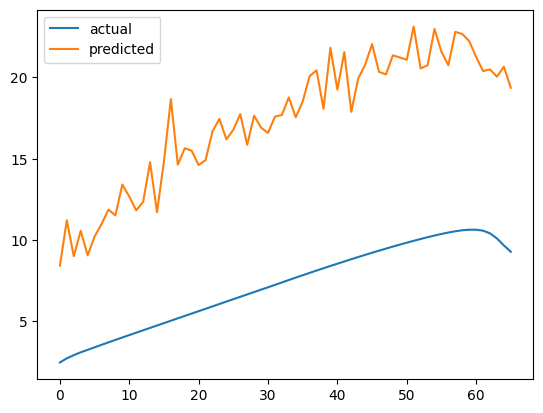

In [200]:
import matplotlib.pyplot as plt

plt.plot(actual.columns, actual.values[2], label='actual')
plt.plot(pred.columns, pred.values[2],  label='predicted')
plt.legend()
plt.show()